In [1]:
%matplotlib inline
import os
os.environ['THEANO_FLAGS'] = 'device=gpu'
import sys
sys.path.append('..')
import matplotlib.pyplot as plt
from tools.common import disp_grid
from IPython.display import Image
from skimage.io import imsave

from keras.models import model_from_json
import os
import joblib
import numpy as np
from lightjob.cli import load_db
#from skimage.io import imread
from tools.common import find_generation_job, find_training_job, to_generation, compute_sample_objectness, resize_set
from IPython.display import Image, display
from lightjob.cli import load_db
from lightjob.db import SUCCESS
import pandas as pd
import h5py
import cv2

from skimage.transform import resize

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
from joblib.parallel import delayed, Parallel
from sklearn.neighbors import NearestNeighbors


def disp_pred(pred, h=20, w=100, y0=25, fontsize=0.9):
    nb_classes = len(pred)
    img = np.zeros((nb_classes * h, w, 3))
    cv2.rectangle(img,(0,0),(img.shape[1],img.shape[0]),(0.3,0.3,0.3),3)
    pad = 0
    col = [[0, 0, 1]] * nb_classes
    for i in range(nb_classes):
        p = int(w * pred[i])
        img[i*(h+pad):i*(h+pad)+h, 0:p, :] = col[i]
    font = cv2.FONT_HERSHEY_SIMPLEX
    for i in range(nb_classes):
        cv2.putText(img,str(i),(10,y0+h*i), font, fontsize,(1,1,1),1,cv2.LINE_AA)
        cv2.rectangle(img,(0, i*(h+pad)),(w, i*(h+pad)+h),(0.3,0.3,0.3),2)

    return img

def disp_grid_with_pred(img, preds, h=30, w=200, y0=25, fontsize=0.9):
    img = resize_set(img, 100, 100)
    img_ = np.zeros((img.shape[0], 3, img.shape[2]*2, img.shape[3]*2))
    img_[:, :, 0:img.shape[2], 0:img.shape[3]] = img[:, :, :, :]
    for i, pr in enumerate(preds):
        text= disp_pred(pr, h=h, w=w, y0=y0, fontsize=fontsize)
        text = resize(text, (img.shape[2], img.shape[3]))
        text = text.transpose((2, 0, 1))
        img_[i, :, 0:img.shape[2], img.shape[3]:] = text
    img_ = disp_grid(img_)
    return img_

from tools.common import resize_set
import shutil
from tools.common import compute_objectness, compute_objectness_renyi, compute_sample_objectness, compute_sample_objectness_renyi
def load_h5(filename):
    f = h5py.File(filename)
    X = f['X']
    nb = f.attrs['nb']
    X = X[0:nb]
    X = np.array(X)
    X = X[np.isnan(X).sum(axis=(1,2,3))==0]
    return X

Using gpu device 0: Tesla K20Xm (CNMeM is enabled with initial size: 95.0% of memory, cuDNN 5005)
/home/mcherti/work/code/external/scikit-learn/sklearn/cross_validation.py:43: DeprecationWarning: This module has been deprecated in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
Using Theano backend.


In [18]:
model_folder = '../tools/models/external/fonts'
arch = (open(os.path.join(model_folder, 'model.json'))).read()
model = model_from_json(arch)
model.load_weights(os.path.join(model_folder, 'model.pkl'))

## checking all generated

In [29]:
#X = joblib.load('../../external/dcgan_code/mnist/models/uncond_dcgan/200_gen.npz') # gan
X = load_h5('../exported_data/datasets/jobset83.hdf5')
#X = load_h5('../exported_data/datasets/jobset76.hdf5')

In [30]:
%%time
batch_size = 2048
preds = []
for i in range(0, len(X), batch_size):
    x = X[i:i+batch_size]
    preds.append(model.predict(x))
preds = np.concatenate(preds, axis=0)

CPU times: user 1min 47s, sys: 9.94 s, total: 1min 56s
Wall time: 1min 56s


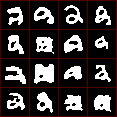

In [32]:
#### CLASS = 1
indices = np.arange(len(X))
#indices = indices[compute_objectness(preds)>0.1]

n = 'abcdefghijklmnopqrstuvwxyz'.index('a')
p=preds[:, n]
indices = indices[np.argsort(p[indices])[::-1]]
#indices = indices[p[indices]>0.5]
img = X[indices]
img = disp_grid(img[0:16], border=1, bordercolor=(0.3, 0, 0))
imsave('imgs/out.png', img)
Image('imgs/out.png')

In [6]:
preds_orig = preds.copy()

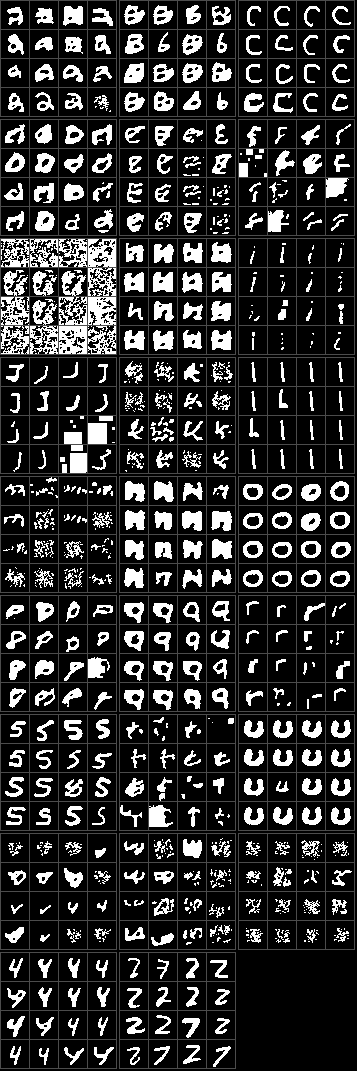

In [33]:
nbrows = 9
nbcols = 3
border = 1
space = 2
s = (28+border) * 4 + border
img_all = np.zeros((nbrows * (s+space), nbcols * (s+space)  ))
for i in range(nbrows):
    for j in range(nbcols):
        if i*nbcols+j>=26:
            break
        p=preds[:, i*nbcols+j]        
        indices = indices[np.argsort(p[indices])[::-1]]
        #indices = indices[p[indices]>0.5]
        img = X[indices]
        img = disp_grid(img[0:16], border=border, bordercolor=(0.3, 0, 0), shape=(4,4))
        img_all[i*(s+space):i*(s+space) + s, j*(s+space):j*(s+space) + s] = img[:,:,0]
imsave('imgs/all.png', img_all)
Image('imgs/all.png')

In [ ]:
p_real=preds_real[:, 5]
real = Xreal[yreal==5][np.argsort(p_real[yreal == 5])[::-1][0:100]]
fake = X[np.argsort(p)[::-1]][0:100]


points_real = real.reshape((real.shape[0], -1))
points_fake = fake.reshape((fake.shape[0], -1))

In [ ]:
nn = NearestNeighbors(n_neighbors=30)
nn.fit(points_real)
dist, indices = nn.kneighbors(points_fake)

In [ ]:
neighb = indices[:]
print(indices.shape)
h=28
w=28
c=1
img = np.zeros((h*indices.shape[0], w*indices.shape[1]))
for y in range(indices.shape[0]):
    for x in range(indices.shape[1]):
        img[y*h:y*h+h, x*w:x*w+w] = fake[y] if x== 0 else real[indices[y, x-1]]
        img[y*h:y*h+h, x*w:x*w+1]=0.3 if x>1 else 1
        img[y*h:y*h+1, x*w:x*w+w+1]=0.3 if x>0 else 1
imsave('imgs/neigh.png', img)
Image('imgs/neigh.png')

## checking stats of jobs

In [ ]:
db = load_db()
jobs = db.jobs_with(state=SUCCESS, where='jobset83')
S = [j['summary'] for j in jobs]

In [ ]:
jobs_gen = to_generation(jobs, db=db)

In [ ]:
field = 'stats.out_of_the_box_classification.m2.objectness'
indices = np.arange(len(jobs))
for i in range(len(jobs_gen)):
    j = jobs_gen[i]
    v = db.get_value(j, field, if_not_found=None)
    if not v:print('Misssing generation jobs from training job : {}, skip it.'.format(jobs[i]['summary']))

In [ ]:
indices = np.arange(len(jobs))
objectness = map(lambda j:db.get_value(j, field, if_not_found=np.nan), jobs_gen)
objectness = np.array(objectness)
indices = filter(lambda ind:not np.isnan(objectness[ind]), indices)
indices = sorted(indices, key=lambda i:objectness[i])
indices = indices[::-1]
images = ['../exported_data/figs/generated/jobset{:05d}/{}.png'.format(int(jobs[i]['where'][6:]), jobs_gen[i]['summary']) 
          for i in indices]
print(jobs_gen[indices[1]]['summary'])
for i in range(len(images)):
    print(jobs_gen[indices[i]]['summary'])
    shutil.copy(images[i], 'export/{:05d}.png'.format(i))
    #display(Image(images[i]), width=100, height=100)

## objectness score

In [ ]:
objectness = compute_sample_objectness_renyi(preds,alpha=1.1)

In [ ]:
ind = np.argsort(objectness)[::-1]
X_sorted = X[ind]
preds_sorted = preds[ind]
objectness_sorted = objectness[ind]

In [ ]:
sample = np.arange(len(X))
np.random.shuffle(sample)
sample = sample[0:100]
objectness_sampled = objectness[sample]
X_sampled = X[sample]
preds_sampled = preds[sample]
X_sampled = X_sampled[np.argsort(objectness_sampled)[::-1]]
preds_sampled = preds_sampled[np.argsort(objectness_sampled)[::-1]]

In [ ]:
im = disp_grid_with_pred(X_sorted[0:100], preds_sorted[0:100], h=200)
imsave('imgs/out.png', im)
Image('imgs/out.png', width=800, height=800)